In [1]:
# Importing the libraries
import os
import shutil
import random
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Importing the dataset
df_meta = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df_meta.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
df_meta.shape

(9912, 14)

<AxesSubplot:>

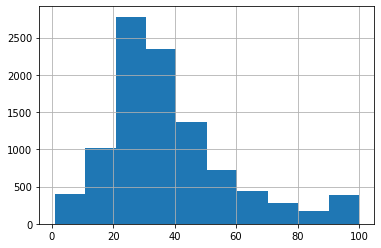

In [4]:
df_meta["Pawpularity"].hist()

In [5]:
# Creating seperate directories for train, test and validation sets
WORK_DIR = "."
os.mkdir(WORK_DIR + "/train")
os.mkdir(WORK_DIR + "/test")
os.mkdir(WORK_DIR + "/validation")

In [6]:
# Creating a config class to store all our configurations
class config:
    
    # Image and tabular paths
    DIRECTORY_PATH = "../input/petfinder-pawpularity-score"
    IMAGES_FOLDER_PATH = DIRECTORY_PATH + "/train"
    METADATA_FILE = DIRECTORY_PATH + "/train.csv"
    
    WORK_DIRECTORY = "."
    TRAIN_IMAGES_FOLDER = WORK_DIRECTORY + "/train"
    TEST_IMAGES_FOLDER = WORK_DIRECTORY + "/test"
    VALIDATION_IMAGES_FOLDER = WORK_DIRECTORY + "/validation"
    TRAIN_DATA = WORK_DIRECTORY + "/train.csv"
    TEST_DATA = WORK_DIRECTORY + "/test.csv"
    VALIDATION_DATA = WORK_DIRECTORY + "/validation.csv"
    
    # Input parameters for data preprocessing
    TARGET_NAME = "Pawpularity"
    VALIDATION_SIZE = 0.15
    TEST_SIZE = 0.10
    SEED = 42
    
    # Tensorflow settings for model training
    IMAGE_HEIGHT = 299
    IMAGE_WIDTH = 299
    NO_CHANNELS = 3
    BATCH_SIZE = 32
    EPOCHS = 20
    DROPOUT = 0.5
    LEARNING_RATE = 0.001
    PATIENCE = 5

In [7]:
# Creating a function that gives a file path given its input
def image_path(input_image, dirname=config.IMAGES_FOLDER_PATH):
    return os.path.join(dirname, f"{input_image}.jpg")

In [8]:
# Creating a new column containing the file path for each image
df_meta["image_path"] = df_meta["Id"].apply(lambda name: image_path(name))

In [9]:
df_meta.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,image_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...


In [10]:
# Creating strats for the pet pawpularity score
df_meta["Pawpularity_score_cat"] = pd.cut(df_meta["Pawpularity"], bins=[0.0, 20.0, 40.0, 60.0, 80.0, np.inf], labels=[1, 2, 3, 4, 5])
df_meta["Pawpularity_score_cat"].head()

0    4
1    3
2    2
3    1
4    4
Name: Pawpularity_score_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

<AxesSubplot:>

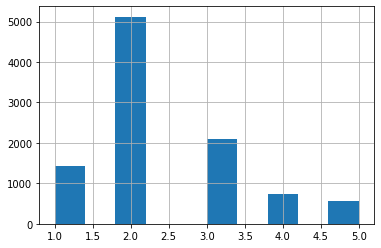

In [11]:
df_meta["Pawpularity_score_cat"].hist()

In [12]:
# Splitting the dataset into train_full and test
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=config.TEST_SIZE, random_state=config.SEED)
for train_index, test_index in split.split(df_meta, df_meta["Pawpularity_score_cat"]):
    strat_train_set_full = df_meta.loc[train_index]
    strat_test_set = df_meta.loc[test_index]

In [13]:
# Checking the value_counts in our test data based on the score
strat_test_set["Pawpularity_score_cat"].value_counts()

2    512
3    209
1    142
4     73
5     56
Name: Pawpularity_score_cat, dtype: int64

In [14]:
# Splitting the dataset into train and validation
split = StratifiedShuffleSplit(n_splits=1, test_size=config.VALIDATION_SIZE, random_state=config.SEED)
for train_index, val_index in split.split(strat_train_set_full, strat_train_set_full["Pawpularity_score_cat"]):
    strat_train_set = df_meta.loc[train_index]
    strat_val_set = df_meta.loc[val_index]

In [15]:
# Checking the value_counts in our val data based on the score
strat_val_set["Pawpularity_score_cat"].value_counts()

2    697
3    287
1    194
4     91
5     69
Name: Pawpularity_score_cat, dtype: int64

In [16]:
# Copying the images from main folder to their respective split dir.
def copy_images(data, destination_dir):
    for source_path in data["image_path"]:
        shutil.copy(source_path, destination_dir)

copy_images(strat_train_set, config.TRAIN_IMAGES_FOLDER)
copy_images(strat_val_set, config.VALIDATION_IMAGES_FOLDER)
copy_images(strat_test_set, config.TEST_IMAGES_FOLDER)

In [17]:
# Dropping the Pawpularity_score_cat column and resetting index from train,val and test data
for set_ in (strat_train_set, strat_val_set, strat_test_set):
    set_.drop(["Pawpularity_score_cat", "image_path"], axis=1, inplace=True)
    set_.reset_index(drop=True, inplace=True)

In [18]:
# Creating a new column containing the file path for each image
strat_train_set["image_path"] = strat_train_set["Id"].apply(lambda name: image_path(name, config.TRAIN_IMAGES_FOLDER))
strat_val_set["image_path"] = strat_val_set["Id"].apply(lambda name: image_path(name, config.VALIDATION_IMAGES_FOLDER))
strat_test_set["image_path"] = strat_test_set["Id"].apply(lambda name: image_path(name, config.TEST_IMAGES_FOLDER))

In [19]:
strat_train_set["image_path"].head()

0    ./train/15f7cde7ed93092bbd02dcd9cbf69e61.jpg
1    ./train/4b439fc7d5f5f68fa366aee88405ec9a.jpg
2    ./train/947564d9d53bb7ca769214d95e310b68.jpg
3    ./train/d87c509bc16c8f53478ab9b434e522cc.jpg
4    ./train/a48e5ca49c6a9459dba5166b2355125b.jpg
Name: image_path, dtype: object

In [20]:
# Saving the train, test and val data into csv files
strat_train_set.to_csv(config.TRAIN_DATA, index=False)
strat_val_set.to_csv(config.VALIDATION_DATA, index=False)
strat_test_set.to_csv(config.TEST_DATA, index=False)

In [21]:
# Creating ImageDataGenerator for our dataset
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=strat_train_set,
    x_col="image_path",
    y_col="Pawpularity",
    batch_size=config.BATCH_SIZE,
    seed = config.SEED,
    shuffle=True,
    class_mode="raw",
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb"
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=strat_val_set,
    x_col="image_path",
    y_col="Pawpularity",
    batch_size=config.BATCH_SIZE,
    seed = config.SEED,
    shuffle=True,
    class_mode="raw",
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb"
)

Found 7582 validated image filenames.
Found 1338 validated image filenames.


In [22]:
# Creating an exponential learning rate scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=config.LEARNING_RATE, s=20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [23]:
# Using callbacks to save model parameters and perform early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint("pawpularity_score.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=config.PATIENCE, restore_best_weights=True)

In [24]:
# Calculating the different step size for the model while training
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n // validation_generator.batch_size

In [25]:
# Using transfer Learning to create a Xception model
xcep_net = keras.models.load_model("../input/keras-applications-models/Xception.h5")
xcep_net.trainable=False

xception_model = keras.models.Sequential([
    keras.layers.Input(shape=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH, 3)),
    xcep_net,
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(config.DROPOUT),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1)
])

2021-11-27 02:29:05.587127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 02:29:05.704972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 02:29:05.705836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 02:29:05.706986: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [26]:
# Compiling the model
xception_model.compile(loss=keras.losses.MeanSquaredError(), 
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.RootMeanSquaredError()]
            )

In [27]:
# Fitting the model
xcp_history = xception_model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=config.EPOCHS,
                    validation_data=validation_generator, validation_steps=STEP_SIZE_VALIDATION,
                    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]
                   )

2021-11-27 02:29:12.533638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-27 02:29:16.425870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


236/236 [==============================] - 127s 503ms/step - loss: 1158.1185 - root_mean_squared_error: 34.0311 - val_loss: 580.8333 - val_root_mean_squared_error: 24.1005


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
236/236 [==============================] - 117s 496ms/step - loss: 434.9081 - root_mean_squared_error: 20.8545 - val_loss: 337.3733 - val_root_mean_squared_error: 18.3677
Epoch 3/20
236/236 [==============================] - 114s 481ms/step - loss: 365.8841 - root_mean_squared_error: 19.1281 - val_loss: 336.9746 - val_root_mean_squared_error: 18.3569
Epoch 4/20
236/236 [==============================] - 116s 491ms/step - loss: 357.6013 - root_mean_squared_error: 18.9104 - val_loss: 330.7681 - val_root_mean_squared_error: 18.1870
Epoch 5/20
236/236 [==============================] - 115s 489ms/step - loss: 350.4446 - root_mean_squared_error: 18.7202 - val_loss: 333.0731 - val_root_mean_squared_error: 18.2503
Epoch 6/20
236/236 [==============================] - 116s 490ms/step - loss: 350.2790 - root_mean_squared_error: 18.7157 - val_loss: 334.3909 - val_root_mean_squared_error: 18.2864
Epoch 7/20
236/236 [==============================] - 115s 486ms/step - loss: 347.6424 - r

In [28]:
# Evaluating the model on Validation Dataset
xception_model.evaluate(validation_generator, steps=STEP_SIZE_VALIDATION)

41/41 [==============================] - 17s 413ms/step - loss: 328.6160 - root_mean_squared_error: 18.1278


[328.61602783203125, 18.127769470214844]

In [29]:
# Creating an ImageDataGenerator for the test dataset
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=strat_test_set,
    x_col="image_path",
    y_col="Pawpularity",
    batch_size=config.BATCH_SIZE,
    seed = config.SEED,
    shuffle=False,
    class_mode="raw",
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb"
)

Found 992 validated image filenames.


In [30]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [31]:
# Predicting values for the test dataset
y_pred = xception_model.predict(test_generator)
y_pred[:5]

array([[38.019775],
       [46.040356],
       [34.984978],
       [23.426523],
       [25.642958]], dtype=float32)

In [32]:
# Getting the actual values of the test dataset
y_test = np.array([])
num_batches = 0
for _, y in test_generator:
    y_test = np.append(y_test, y)
    num_batches += 1
    if num_batches == STEP_SIZE_TEST:
        break
y_test[:5]

array([40., 35., 40., 30., 24.])

In [33]:
# Importing metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Printing the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 297.97143235437517
Root Mean Squared Error: 17.261849042161593
Mean Absolute Error: 12.82961844052038


In [34]:
# Evaluating the model on test dataset
xception_model.evaluate(test_generator, steps=STEP_SIZE_TEST)

31/31 [==============================] - 12s 395ms/step - loss: 297.9714 - root_mean_squared_error: 17.2618


[297.971435546875, 17.26184844970703]

# Making Predictions on the Competition Test data

In [35]:
df_test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
df_test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [36]:
# Creating a test data generator for our final submission
final_test_gen = test_datagen.flow_from_directory("../input/petfinder-pawpularity-score",
                                                  classes=['test'],
                                                  class_mode=None, target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
                                                  batch_size=1
                                                 )

Found 8 images belonging to 1 classes.


In [37]:
# Predicting values for our Test dataset
y_final_pred = xception_model.predict(final_test_gen)

In [38]:
df_test["Pawpularity"] = y_final_pred

In [39]:
submissions = pd.DataFrame(df_test[["Id", "Pawpularity"]])
submissions

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,50.090115
1,43a2262d7738e3d420d453815151079e,52.342354
2,4e429cead1848a298432a0acad014c9d,51.675934
3,80bc3ccafcc51b66303c2c263aa38486,49.533035
4,8f49844c382931444e68dffbe20228f4,50.031746
5,b03f7041962238a7c9d6537e22f9b017,52.675972
6,c978013571258ed6d4637f6e8cc9d6a3,52.673912
7,e0de453c1bffc20c22b072b34b54e50f,51.978912


In [40]:
# Saving the Submission File
submissions.to_csv("submission.csv", index=False)